In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import io
from tqdm import tqdm

2023-11-23 13:18:51.808198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 13:18:51.808298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 13:18:51.810222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 13:18:51.836380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 13:18:54.836034: W tensorflow/compiler/tf2

In [2]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from misc.utils import get_dict_item

In [3]:
logdir = '../logs'
net = 'FNO1d'
version_dirs = glob.glob(os.path.join(logdir, net, '*/'))

data = {'_'.join(os.path.normpath(version_dir).split('/')[-2:]) : {'dir' : version_dir} for version_dir in version_dirs}

data

{'FNO1d_aug1_KdV_seed2': {'dir': '../logs/FNO1d/aug1_KdV_seed2/'},
 'FNO1d_aug1_KdV_seed1': {'dir': '../logs/FNO1d/aug1_KdV_seed1/'},
 'FNO1d_aug1_KdV_seed3': {'dir': '../logs/FNO1d/aug1_KdV_seed3/'},
 'FNO1d_aug0_KdV_seed2': {'dir': '../logs/FNO1d/aug0_KdV_seed2/'},
 'FNO1d_aug0_KdV_seed1': {'dir': '../logs/FNO1d/aug0_KdV_seed1/'},
 'FNO1d_aug0_KdV_seed3': {'dir': '../logs/FNO1d/aug0_KdV_seed3/'}}

In [4]:
# k, d = get_dict_item(data, idx = 4)
# print(k)

# version_dir = d['dir']
# filenames = os.listdir(version_dir)
# events = [file for file in filenames if file.startswith('events')]
# filename = events[1]

# tags = set()
# for e in tf.compat.v1.train.summary_iterator(os.path.join(version_dir, filename)):
#     for v in e.summary.value:
#         tags.add(v.tag)
# print(tags)

# file_path = os.path.join(version_dir, filename)
# file_path

In [5]:
def get_results(version_dir, split = 'val'):

    losses = []
    images = []

    for filename in os.listdir(version_dir):
        if 'events.out.tfevents' in filename:

            file_path = os.path.join(version_dir, filename)
            raw_dataset = tf.data.TFRecordDataset(file_path)

            for raw_record in raw_dataset:
                event = tf.compat.v1.Event.FromString(raw_record.numpy())
                for v in event.summary.value:
                    if v.tag == f'{split}_loss':
                        losses.append(v.simple_value)

                    if v.tag == f'{split}_plot':
                        image_enc = v.image.encoded_image_string
                        image = Image.open(io.BytesIO(image_enc))
                        images.append(image)
    
    losses = np.array(losses)
    return losses, images

In [6]:
# raw_dataset = tf.data.TFRecordDataset(file_path)

# for raw_record in raw_dataset:
#     event = tf.compat.v1.Event.FromString(raw_record.numpy())
#     for v in event.summary.value:
#         if v.tag == 'val_loss':
#             # print(v.simple_value)
#             val_losses.append(v.simple_value)
#             # print()

#         if v.tag == 'val_plot':
#             image_enc = v.image.encoded_image_string
#             image = Image.open(io.BytesIO(image_enc))
#             images.append(image)


In [7]:
def get_val_loss(version_dir):
    val_loss_values = []
    for filename in os.listdir(version_dir):
        if 'events.out.tfevents' in filename:
            for e in tf.compat.v1.train.summary_iterator(os.path.join(version_dir, filename)):
                for v in e.summary.value:
                    if v.tag == 'val_loss':
                        val_loss_values.append(v.simple_value)
    val_loss_values = np.array(val_loss_values)
    return val_loss_values

def get_color(version):
    if 'aug0' in version:
        return 'tab:blue'
    elif 'aug1' in version:
        return 'tab:orange'
    else:
        return 'tab:green'

In [8]:
for version, version_dict in tqdm(data.items()):
    version_dict['val_loss'], version_dict['val_plot'] = get_results(version_dict['dir'])
    version_dict['color'] = get_color(version)

100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


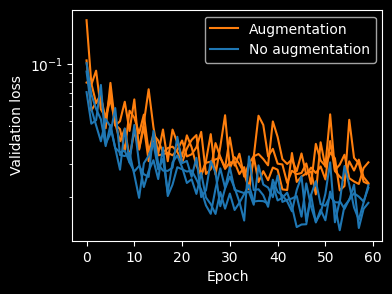

In [9]:
plt.style.use('dark_background')


fig, axs = plt.subplots(1, 1, figsize=(4, 3))
for version, version_dict in data.items():

    if 'seed1' in version:
        if 'aug1' in version:
            label = 'Augmentation'
        elif 'aug0' in version:
            label = 'No augmentation'
    else:
        label = ''

    axs.plot(version_dict['val_loss'], label=label, color=version_dict['color'])
axs.set_xlabel('Epoch')
axs.set_ylabel('Validation loss')
axs.set_yscale('log')
axs.legend()
plt.show()

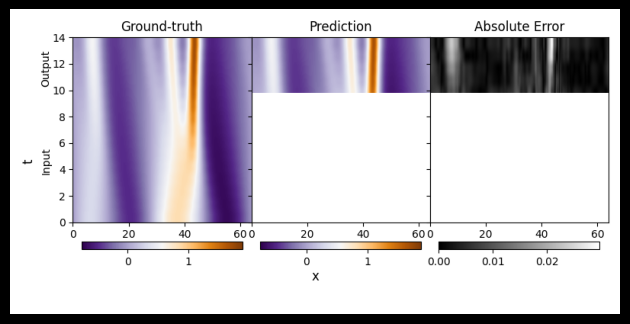

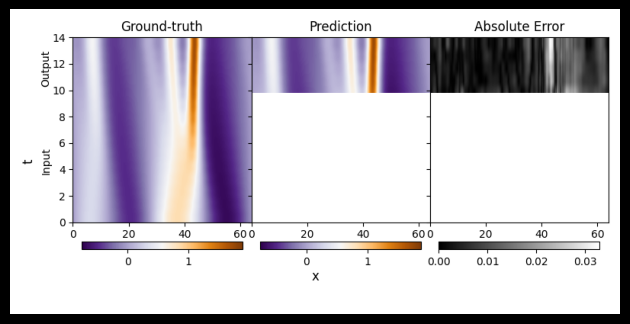

In [10]:
keys = ['FNO1d_aug0_KdV_seed1', 'FNO1d_aug1_KdV_seed1']
for key in keys:
    images = data[key]['val_plot']
    im = images[-1]
    plt.figure(tight_layout=True)
    plt.imshow(im)
    plt.axis('off')
    plt.show()